In [6]:
from simulation import Individual
import numpy as np
import matplotlib.pyplot as plt

In [9]:
"""
Using the example from the paper page 6 last paragraph and
first paragraph page 7
"""
strategyOne = np.array([[0.0,0.1,0.0], [0.2,0.1,0.5]])
strategyTwo = np.array([[0.1,0.5,0.1], [0.7,0.2,0.5]])
m = 2
omega = 2

In [10]:
individualOne = Individual(1, strategyOne, False)
individualTwo = Individual(1, strategyTwo, False)

In [11]:
individualOne

[Wealth = 1]
Strategy:
[[0.  0.1 0. ]
 [0.2 0.1 0.5]]

----------------------------------
# Reading .dat file
Reading out the .dat file

In [34]:
filename= "TestSimulation.dat"
filename = "TestHeteroSimulation.dat"

In [3]:
def file_len(fname):
    """ Returns number of lines in the file
    """
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

file_len(filename)

10009

In [38]:
def readContributionFileToData(fileName, heterogeneous, rounds, numGenerations=None):
    """ Read the contributions per generation of a file
        
        Attributes:
            - fileName(str): String of the file name/path
            - heterogeneous(bool): Tells if the data is heterogeneous
            - rounds(int): Number of rounds
            - numGenerations(int): Number of generations. Default is None, then it is manually calculated based on the file length
        
        Returns a multidimensional numpy array with the average contribution level:
            - (NumGen,rounds) in the case of homogeneous
            - (NumGen,2,rounds) in the heterogeneous where dimension 1 has is the health status.
    """
    lenfile = file_len(fileName)
    
    if heterogeneous:
        
        linesHeader = 9
        linesSummary = 3
        linesPerGeneration = 2
        
        if numGenerations is None:
            linesGenerations = lenfile - linesHeader -linesSummary
            numGenerations = int(linesGenerations/linesPerGeneration)
            
        contribution = np.empty(shape = (numGenerations,2,rounds))
        
        with open(fileName) as file:
            for i, line in enumerate(file):
                if i < linesHeader:
                    continue
                if i >= lenfile - linesSummary:
                    continue
                
                lineWealthType = (i-linesHeader)%linesPerGeneration # 0 = Rich, 1=Poor
                generation = (i-linesHeader)//linesPerGeneration
                
                if lineWealthType==0:# Rich
                    contribution[generation,0] = np.fromstring(line[2:],sep=" ") # remove the first two characters
                else: # Poor
                    contribution[generation,1] = np.fromstring(line[2:],sep=" ")
        
        
    else: # Is homogeneous. In this case the contributions are just individual
        
        linesHeader = 7
        linesSummary = 2
        
        if numGenerations is None:
            numGenerations = lenfile - linesHeader -linesSummary
        
        contribution = np.empty(shape=(numGenerations,rounds))
        
        with open(fileName) as file:
            for i, line in enumerate(file):
                if i < linesHeader:
                    continue
                if i >= lenfile - linesSummary:
                    continue
                contribution[i-linesHeader] = np.fromstring(line,sep=" ")
                
    return contribution

contributionArray = readContributionFileToData(filename,True,4)
print(contributionArray.shape)
print(contributionArray[:3])
print(contributionArray[-3:])

(10000, 2, 4)
[[[0.131364 0.116867 0.124591 0.103686]
  [0.110723 0.078997 0.01636  0.003551]]

 [[0.134974 0.138928 0.134973 0.108955]
  [0.104079 0.077728 0.010794 0.002323]]

 [[0.149297 0.136876 0.153698 0.141395]
  [0.084747 0.053823 0.00793  0.002467]]]
[[[0.139633 0.156932 0.03029  0.003257]
  [0.       0.       0.       0.      ]]

 [[0.137211 0.170381 0.03187  0.003427]
  [0.       0.       0.       0.      ]]

 [[0.133578 0.178905 0.034165 0.003669]
  [0.       0.       0.       0.      ]]]


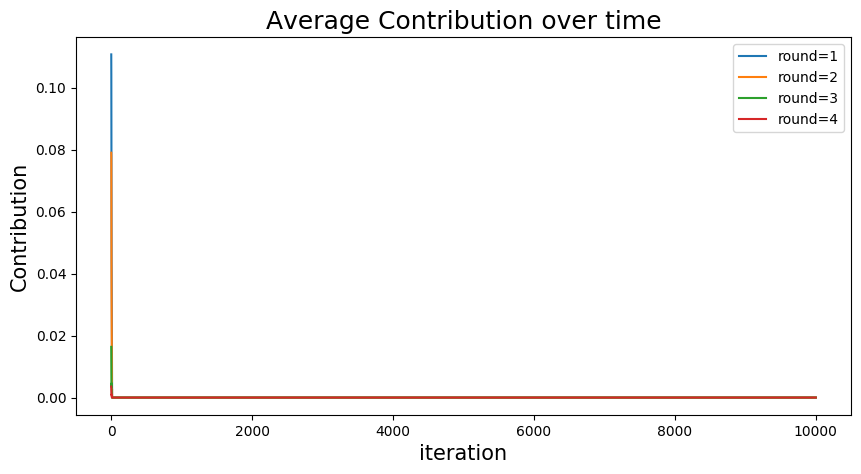

In [40]:
def plotContributionVsGeneration(contributionArray,plotRich=True):
    """ Plot contribution versus itteration
        plotRich = True the rich are plot else the poor are plot
        
    """
    isHetero = len(contributionArray.shape)==3 # boolian that tells if it is heterogenous. 
    if isHetero:
        IndexWealthType = 0 if plotRich else 1
    
    rounds = contributionArray.shape[-1]
    fig = plt.figure(figsize=(10,5),dpi=100)
    
    for r in range(0,rounds):
        if isHetero:# Is hetrogenious
            plt.plot(contributionArray[:,IndexWealthType,r],label=f"round={r+1}")
        else:
            plt.plot(contributionArray[:,r],label=f"round={r+1}")
    
    plt.xlabel("iteration",fontsize=15)
    plt.ylabel("Contribution",fontsize=15)
    plt.title("Average Contribution over time",fontsize=18)
    plt.legend()
    #plt.savefig("Contribution")
    
    return fig
    
fig = plotContributionVsGeneration(contributionArray,plotRich=False)

In [42]:
def readHeader(filename):
    """ Extract header information return this in a dictionary"""
    # Start with empty dictionary
    Header = {}
    with open(filename) as file: # Go over each line one by one and add it to the dictionary
        Header["heterogeneous"] = bool(int(file.readline()))
        Header["popSize"] = int(file.readline())
        
        if Header["heterogeneous"]==False:
            Header["wealthRich"] = float(file.readline())
        else:
            Header["wealthRich"] = float(file.readline())
            Header["wealthPoor"] = float(file.readline())
            
        Header["numberOfRounds"] = int(file.readline())
        Header["typeOfRiskCurve"] = int(file.readline())
        
        if Header["heterogeneous"]==False:
            Header["alphaRich"] = float(file.readline())
        else: 
            Header["alphaRich"] = float(file.readline())
            Header["alphaPoor"] = float(file.readline())
            
        Header["lambda"] = float(file.readline())
        
    return Header

readHeader(filename)

{'alphaPoor': 0.8,
 'alphaRich': 0.5,
 'heterogeneous': True,
 'lambda': 1.0,
 'numberOfRounds': 4,
 'popSize': 100,
 'typeOfRiskCurve': 1,
 'wealthPoor': 1.0,
 'wealthRich': 4.0}

In [49]:
def readSummary(filename, heterogeneous):
    """ Read the summary of a file and return it in a dictionary"""
    lenFile = file_len(filename)
    if heterogeneous:
        lenSummary = 3
    else: # homogeneous
        lenSummary = 2
    
    summary = {}
    # Sadly I don't know an easy way to just start at the end of a file.
    countSummaryLines = 0 # Have a counter that keeps track which summary line we are evaluating

    with open(filename) as file:
        for i, line in enumerate(file):
            if i<(lenFile-lenSummary):
                continue
            if i==lenFile-1: # Remove last newline character from the list line else the np.fromstring doesn't work
                line=line[:-2]
            
            if countSummaryLines==0:
                summary["AverageContribution"] = float(line)
            elif countSummaryLines==1:
                summary["AverageContributionPerRoundRich"] = np.fromstring(line,sep=" ")
            elif heterogeneous and countSummaryLines==2:
                summary["AverageContributionPerRoundPoor"] = np.fromstring(line,sep=" ")
            
            countSummaryLines+=1
    
    return summary

readSummary(filename,True)
    

{'AverageContribution': 0.242318,
 'AverageContributionPerRoundPoor': array([5.6e-05, 3.8e-05, 6.0e-06, 0.0e+00]),
 'AverageContributionPerRoundRich': array([0.231239, 0.0078  , 0.002475, 0.      ])}